# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=(2**16),alternate_sign=True, ngram_range = (1,2))
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    #toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    #toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['exclaim_count'] = toxic_data["comment_text"].str.count("\!")
    toxic_data["s_count"] = toxic_data["comment_text"].str.count("shit") + toxic_data["comment_text"].str.count("SHIT")
    #toxic_data["h_count"] = toxic_data["comment_text"].str.count("hell") + toxic_data["comment_text"].str.count("HELL")
    
    
    X_quant_features = toxic_data[["s_count", "exclaim_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_train.csv', my_random_seed=95)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

### MODEL: SVM, linear

In [6]:
# from sklearn.svm import LinearSVC
# #svm = linear_model.SGDClassifier()
# #svm.fit(X_train, y_train)

# svm = LinearSVC(C=1000)
# svm.fit(X_train, y_train)

# svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
# svm_performance_train.compute_measures()
# print(svm_performance_train.performance_measures)

### MODEL: logistic regression

In [7]:
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log', alpha=0.00000001)
# lgs.fit(X_train, y_train)

# lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
# lgs_performance_train.compute_measures()
# print(lgs_performance_train.performance_measures)

### MODEL: Naive Bayes

In [8]:
#from sklearn.naive_bayes import MultinomialNB


### MODEL: Perceptron

In [9]:
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron', alpha=0.5)
# prc.fit(X_train, y_train)

# prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
# prc_performance_train.compute_measures()
# print(prc_performance_train.performance_measures)

### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
rdg = linear_model.RidgeClassifier(alpha=10, solver='sag', normalize=True)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 13002, 'Neg': 114654, 'TP': 12728, 'TN': 100514, 'FP': 14140, 'FN': 274, 'Accuracy': 0.887087171774143, 'Precision': 0.47372338841744827, 'Recall': 0.9789263190278419, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(max_depth= 10, random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

### ROC plot to compare performance of various models and fits

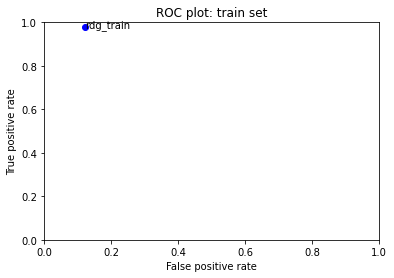

In [12]:
fits = [rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [16]:
rdg_predictions = rdg.predict(X_train)

In [18]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
180
"Things you should know about Wikipedia
 There's always people who are going to take an overactive interest in your talk page and change it to fit what they want it to say...these people have no life.
 Some administrators will lecture you as if you're their own kid...ignore them...that's what I do.
 Saying somebody has a ""hard on"" for your talk page can get you blocked.  But when other people come to your defense in the situation...you really only end up being blocked for 15 minutes.

"
* * * * * * * * * 
255
"::*Pot, meet kettle.    speak! 
"
* * * * * * * * * 
263
seriously.... 

now come on....
* * * * * * * * * 
521
Is anyone from Morphett Vale here? 

Hey, just wondering, is there anyone who lives in Morphett Vale on the site?
* * * * * * * * * 
756
Don't worry, I'll be back! It ain't over!
* * * * * * * * * 
776
Like I said, before, it is true!
* * * * * * * * * 
795
I don't really care who you ignore or what you're currently doing, just don't r

12093
Negro league baseball task-force talk].
* * * * * * * * * 
12397
penmanship 

well, like i said i think your handwriting is one of the things that makes you, well you  and i enjoy writing quite a bit  so i hoped you like my entry so thanks for reading  
>
* * * * * * * * * 
12574
i literally could care less
* * * * * * * * * 
13144
Reply Yo-Yo Ma 
You're using what I said every time I edited and just pinpointed this one sentence. I very well know that to be an American, you think like an American. That's it. However, you're getting way too technical. Beyond technical. Super technical. If some random person starts reading his article and sees that he's an American, he might just have the perception of him being American. Let me ask you what the hell is wrong with putting Chinese-American? It's stupid to like saying you are what you are now, you must forget your past. Outrageous.
* * * * * * * * * 
13161
I have done nothing wrong, so I dont care. I always do what I like and when I 

22362
"
Could it be you support terrorism and want to find a way to attack Israel using deliberate mistranslation and anti-semitic ramblings as a wedge? Accusations of Jews as ""Nazis"" seem like something you and your hezbollah friends do a lot of."
* * * * * * * * * 
22580
quit bugging me- why up on my back?
* * * * * * * * * 
22723
Reconsider the brown eyes and don't trick people to agree with you it's your and my choice ok and i say don't delete it and it's true ok.

Oh and think about when it does come you ok then let's see what will you and i say ok.
* * * * * * * * * 
22825
"::::Oh, I thought he was ""tryna"" make me look stupid.  21:07, 8 June 2006

"
* * * * * * * * * 
22848
Real Madrid Kit 
But let me just say this, Real Madrid isnt the only ones that have excesive detail in the kits if your gonna change it might as well change the Barcelona one too
* * * * * * * * * 
22916
"

You guys sure do assume a lot.  
I am not working ""against"" you guys.
Where did that theory even s

30227
i am ugly so plz do not atack al roker 4 me
* * * * * * * * * 
30643
Messhermit is banned
Messhermit has been banned from editing Alberto Fujimori. Tony Sidaway
* * * * * * * * * 
30651
"

The number one rule of Wikipedia, as shown on every edit:  ""If you don't want your writing to be edited mercilessly or redistributed by others, do not submit it.""  Factual statements are allowed.  It is NOT a requirement to sign.  If it was, I wouldn't be allowed to edit.  Do you guys have a clique as a bunch of self-proclaimed proofreading wannabes?  Because you guys have horrible grammatical, spelling, and proof-reading skills."
* * * * * * * * * 
30675
Oh sorry.  I always seem to leave a mess with my referencing ...
* * * * * * * * * 
30721
When you turn on your shower, and you smell raw sewage, you can thank wikipedia, textbooks, and people who blatently did not listen to science, but in turn promoted dogmatic theories like electrons, for their own political endevor. When you say V=IR lik

39666
"Perhaps add something about the fact The Toy Dolls filmed the video for ""Dig That Groove Baby"" there?"
* * * * * * * * * 
40189
Why not add Metodontia 

Metodontia is an Asian genus of this familiy . Are Asian animals should be treated specially?
* * * * * * * * * 
40204
WOW, ARE YOU RETARDED, you stay on the practice squad during the off-season! THE PRACTICE SQUAD IS IN THE OFFSEASON, though they don't have open practices.
* * * * * * * * * 
40635
From what I've seen with editors other than Eric, the elephant in the room is the issue of baiting/poking the bear/whatever the hell you want to call passive/aggressive baiting. No one wants to touch that one, even though it's uncivil as hell and appears to be the tactic of choice whenever someone wants to get rid of someone or get their way. That's the part that saddens me. darkness
* * * * * * * * * 
41126
Psychonaut|talk]]) 14:09, 17 September 2013
* * * * * * * * * 
41205
Stealth, not a FPS 

Well, go right ahead. Soetermans. T 

48460
Corrected. Thee are countless ahs all over China. D
* * * * * * * * * 
48580
"

"". . . the world's most famous lion?""  Some of use are old enough to remember Elsa, and she was even more famous than a Disney cartoon character lion.  BTW, is it now archaic or outdated to refer to a female lion as a ""lioness?""    "
* * * * * * * * * 
48632
how about you be polite and STFO of business you can't handle.
* * * * * * * * * 
48726
All you have to do to realize this is read the criticism on the book.  Then you'll understand.  I'm only defending the criticism, which is cited, and notable.  You and sleezy are attempting to eliminate some criticism on what you arbitrarily determine to be too much criticism...nice try, but it won't fly.

You're going to have to deal with criticism of things you don't like.  (Gibby )
* * * * * * * * * 
48965
"

 Vandalism at Pinto da Costa 

Well done kid, you got what you want from the start: hide Pinto da Costa's corruption scandal. You cannot say someon

53539
Nixon is an awesome guy that goes to Crooms Academy. 
He's totally titz.
* * * * * * * * * 
53656
Quit changing the bloody article 

If you wanna start something go ahead, but this change is real this time. If you want to check out my refrence, go ahead. The Encyclopedia of Mordern Music can be found at the Calgary Public Library, I have it taken out right now seeing as how I am doing some serious research on Peart, something you wouldn't know about...
* * * * * * * * * 
53676
"

For the record, we tried ""calm and reasonable"" many times.   However, when you have a vigilant troll that recruits his ""friends"" into a swarm, they are all one in the same to me.   I personally, one on one, had a lengthy discussion with Jim Wales.  It does not get any more serious than that.   He overrode everything bye everyone, himself, while I waited.   This due to the fact that I DID involve legal entities and board members.  I was heard.   But I refuse to involve him again in this bullshit.    Y

59278
this guy nailed it on the head! Paralympiakos quit deleting things people alreaddy know! as in ufc undisputed roster. people wnat to know who will be in the game. then when someone tries and confront you as being a bad moderator Paralympiakos deletes or just plain out makes fun of. then tries to ban people when they do the same thing. people have done this in history as well trying to silence people when they did not go the way of the person in charge.... hitler is one.
this will most likely be deleted because he can not make fun of me for this and it is the truth and since Paralympiakos knows he is a horrible moderator.
get off of your power trip Paralympiakos, if not then go fix the ea mma wikipedia page since they have unconfirmed fighters too. here is a lonk since you don't seem to know what it is. http://en.wikipedia.org/wiki/EA_Sports_MMA
* * * * * * * * * 
59527
"Now this is a story all about how my
Life got flipped turned upside down
And I'd like to take a minute just sit

62843
Fund-raising appeal 

How much money are you hoping to raise? How much do you have so far? 96.48.13.234
* * * * * * * * * 
63438
hi i'm angel of sadness 

i'm a 10 years old girl that love gay band tokio hotel and you?
* * * * * * * * * 
63482
Lol. Instead of spamming me a long winded response, why don't you take my advice and explain your edit.
* * * * * * * * * 
63484
Whoever thinks they found a solid reference in Hawley, I suggest you cut the crap and help make the article nonbiased.
* * * * * * * * * 
63594
June 2008 (UTC)
 YOUR THE BULLY IN THIS SITUATION. ON WHO DAMAGES WIKIPEDIA WITH YOUR POLITICAL AGENDA.68.75.54.58  02:15, 19
* * * * * * * * * 
63721
So I suppose it's just a coincidence that you keep showing up at pages I edit? Stop it! 107.10.236.42
* * * * * * * * * 
63805
Hey, pile on! It's the thing to do.
* * * * * * * * * 
63845
I Said the Same of Antonio Margarito page but you got it right he is an American, I never knew that because the kid can't even Speak Engli

66992
Please PERMANENTLY block all editing ability from this ip, my fellow students seem to be moronic dolts. I enjoy contributing, but if I have to give that up in order to keep wikipedia working, I will.
* * * * * * * * * 
67003
How dare you block me without cause you had no right and are abusing your position. If you don't I will demand your immediate removal as an administrator. Tannim
* * * * * * * * * 
67005
I rest my case. Did you get a uniform with this job as well? —Preceding unsigned comment added by 81.141.82.150   
 
-TABTAB 
-TAB
Yeah, that's it, if you can't answer me: Block me. Go ahead. I'll be back......... -)
* * * * * * * * * 
67223
well the first block was due to censorship and also am i supposed to care that some fag on the internet finds me an unconstructive editor. anyways last time i was editing things properly i got warned twice by a guy for not letting him change a fighters name so honestly grow up  wikipedia is useless anyways if it was a legitimate publicati

77433
TODAYS WIKI WORD OF THE DAY IS NIPPLENOOB!
* * * * * * * * * 
77512
just because freaky animal lib-ers are over-represented on that page does not make them right.
* * * * * * * * * 
77555
Do not attack users who cooperate in contributing to wiki articles. 
68.173.95.177 
68.173.95.177
* * * * * * * * * 
77862
try again 83.170.117.88  
still not good enough buddy im still here wheres that blocking i got promised? 77.92.65.179
* * * * * * * * * 
78381
Your source come from a Greek anti Albanian website go to the main page and read all the anti Albanian slogans you are going to tell me tats a valid source
* * * * * * * * * 
78458
TAKE THE PICTURE OFF 

This is pornography.  Take it off this page.

 Xchanter
* * * * * * * * * 
78585
Well, sometimes people tend to forget that this place is an encyclopedia, not a gossip site. Colin is one of my favorite rally idols and I really hope he's still alive.
* * * * * * * * * 
78590
Well, do you think Mibhorovovovsky missed the ball on blockin

87620
listen peeps................this guy is one of these cult members ,its bogus.....his whole trip is bogus ,there is nothing wrong with this topic.
* * * * * * * * * 
87650
cause thats what this is all about, not slavery and being drained of all that you are.  thats why people came to America, bro. the land of the FREE.
* * * * * * * * * 
87837
RE The idea that a camp just for women is unusual until you read the Geneva Convetion 1929 - separating sexes and nationalities into their own camp/section was required. The women from Lidice were sent here where most of them survived.
* * * * * * * * * 
87905
User:Magneil Max 

Read my userpage,
* * * * * * * * * 
87937
.  I'll make good contributions}}
* * * * * * * * * 
88203
Well looky who just got blocked again? You are such a dissembler..
* * * * * * * * * 
88478
Here is the description of minimal, given by beatport.com:   82.209.225.33
* * * * * * * * * 
88511
"Nothing of the kind==

I sought a considered determination, not a defensiv

97723
"

More  lies! There is no consensus and you are just making accusations and going back to your if they do not agree with the all knowing  they are a sockpuppet. The product was gum. Where are the gum photos Ms. Baseball Card Expert? What the hell are you talking about ""use the company's name name as it appeared in the 50s""? As was proven by what you think is my sockpuppet above they company used more than one font for their packaging. You of course just pay lip service since all you care about is being right and will lie to do it. You need to be banned because of your troll like behavior acting like a bully to get what you want. God forbid the mighty baseball card expert  is wrong, that would be such a tragedy!   "
* * * * * * * * * 
98074
Ok.  Sorry to bother you, then.  )  98.212.158.221
* * * * * * * * * 
98375
You are editing unilaterally instead of discussing. I think you may be more interested in getting your way than actually having a discussion about it. Kmines is used

107243
(a person can choose to see the glass as half empty/full in regards to women campaigning for parental leave, against gender segregation, gender neutral language, reproductive health, heterosexism, against gender roles, etc as they all affect men too)
* * * * * * * * * 
107435
Second apperance of the gorilla first in I had an Accident.
Acorrding to the Krusty Krab Training video this is not how the Krusty Krab started
* * * * * * * * * 
107667
REDIRECT Talk:WCW World Television Championship
* * * * * * * * * 
108547
"

You don't know the clan of ""most of those people"" because that's what happens when people stick their nose in something they know nothing about.

1st row: 
Muhammad Abdullah Hassan - Darood
Fatima Jibrell - Darood 
Mohamed Abdullahi Mohamed - Darood
Asli Hassan Abade - Darood
2nd row: 
Hanan Ibrahim - Isaaq
Hadraawi - Isaaq
Iman - Darood 
Sultan Yusuf Ali Kenadid - Darood
Aar Maanta - Darood
Sultan Mohamoud Ali Shire - Darood
Osman Yusuf Kenadid - Darood
Nuruddin

117995
OK, now try saying his name to a Mandarin-speaking person and watch their reaction! )
* * * * * * * * * 
118297
when can I get unbanned?
* * * * * * * * * 
118477
... For an April Fool's joke ... ~~~~
* * * * * * * * * 
118543
ZOMG WHERE DID IT GO????
* * * * * * * * * 
118547
"... And what the HELL does ""attack against the gender"" mean?!?!!? ... Oh, wait. You're one of those that actually buys into the whole ""conspiracy of misogyny"" thing. Ugh. You know, I have my criticisms of Gail Simone's writing, but I usually enjoy it. I just wish she weren't dedicated to being such a hypocrite, liar, and misogynist, and that some of her fans didn't join her in it. Whatever, I should have learned looong ago that actual facts and Wikipedia have a restraining order. "
* * * * * * * * * 
118574
, and people's personal opinions are their own business
* * * * * * * * * 
118641
Artkos, u should stop nagging.  U are like the proverbial creacked record.  Maybe if you got a life other than here

125654
Well I'm not going to get 3RR'd in the face of that.  Over to you -)
* * * * * * * * * 
125813
These guys are my heroes!
* * * * * * * * * 
125833
ignore this nut case 

RationalBlasphemist is fruity as!
* * * * * * * * * 
126531
Say hi to your imaginary girlfriend for me

Unless ofcourse she is a blow up doll. Wikipedians don't have girlfriends you time waster. If you had a girlfriend you wouldn't be making pointless changes to wikipedia to get attention.
* * * * * * * * * 
126615
"
listen up, Sj, are you going to let me show you that you are wrong? first, I offered you my email address. then you could email me. second, you are wrong about the ""attacks"". being ""fed up"" with incompetence on this site is justifiable. you guys see vandals where there is only a desire to bring back some civilized behavior. we aren't all 4 Chan people. some of us have much more education than you will ever have. are smarter than you will ever be. have connections. are unwilling to let you do wha

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [19]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

### MODEL: SVM, linear

In [20]:
# svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
# svm_performance_test.compute_measures()
# print(svm_performance_test.performance_measures)

### MODEL: logistic regression

In [21]:
# lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
# lgs_performance_test.compute_measures()
# print(lgs_performance_test.performance_measures)

### MODEL: Naive Bayes

In [22]:
#nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
#nbs_performance_test.compute_measures()
#print(nbs_performance_test.performance_measures)

### MODEL: Perceptron

In [23]:
# prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
# prc_performance_test.compute_measures()
# print(prc_performance_test.performance_measures)

### MODEL: Ridge Regression Classifier

In [24]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 2961, 'TN': 24378, 'FP': 4314, 'FN': 262, 'Accuracy': 0.8566191446028514, 'Precision': 0.4070103092783505, 'Recall': 0.9187092770710518, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [25]:
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

### ROC plot to compare performance of various models and fits

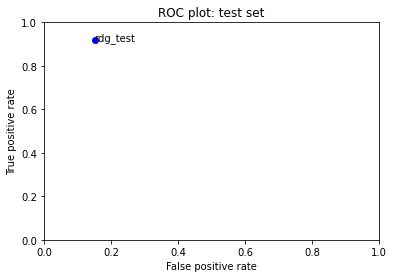

In [26]:
fits = [rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [27]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_test.csv', my_random_seed=95, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 65536)
Look at a few rows of the new quantitative features: 
   s_count  exclaim_count
0        1              0
1        0              0
2        0              0
3        0              0
4        0              0
5        0              0
6        0              0
7        0           

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [28]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])

my_submission["prediction"] = rdg.predict(X_test_submission)
# concatenate predictions to the id
# my_submission["prediction_1"] = svm.predict(X_test_submission)
# # look at the proportion of positive predictions
# # print(my_submission['prediction_1'].mean())

# my_submission["prediction_2"] = prc.predict(X_test_submission)

# my_submission["prediction_3"] = rdg.predict(X_test_submission)

# my_submission["prediction_4"] = lgs.predict(X_test_submission)

# #my_submission["prediction"] = my_submission["prediction_1"] + my_submission["prediction_2"] + my_submission["prediction_3"] + my_submission["prediction_4"]

# my_submission["prediction"] = my_submission[['prediction_1',"prediction_2", "prediction_3", "prediction_4"]].sum(axis=1) >= 2

# my_submission.head()

print(my_submission['prediction'].mean())

0.3461126635501815


In [29]:
raw_data.head()

,id,comment_text,exclaim_count,s_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0,1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,0


In [30]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,True
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [31]:
my_submission.shape

(153164, 2)

In [32]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_submission_FINAL.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation